# Introducción al trabajo

**Modelo predictivo del sentimiento de las reseñas de IMDb**
+ Contexto y Finalidad:
    El dataset escogido cuenta con casi 50,000 reseñas de películas recogidas de la página web IMDb. Este dataset cuenta con 5 columnas; nº de reseña, reseña en inglés, reseña traducida al español, etiqueta de sentimiento de la reseña en inglés y etiqueta de sentimiento para la resea en español.
    La finalidad es crear un modelo predictivo que sea capaz de decir si una reseña (en español) es de sentimiento positivo o negativo. Este modelo podrá catalogar automáticamente el sentimiento de las reseñas escritas en la página web en un futuro. 

+ Proceso a seguir:
    Para realizar este proyecto, empezaremos con un análisis profundo de los datos, lo que nos dará una idea de que datos tenemos y como están estructurados. En este paso, dejaremos el dataset listo para el preprocesamiento de los datos antes de la creación del modelo.
    En la EDA, deberemos observar los datos y tomar decisiones a cerca de como los gestionamos.

    Seguidamente viene el preprocesamiento de los datos. En este punto, deberemos dejar los datos excelentemente preparados para que el modelo predictivo los pueda entender.
    En el preprocesamiento de los datos o NLP deberemos limpiar todas las reseñas de signos y textos innecesarios, lematizar, tokenizar y vectorizar las reseñas y, dividir el conjunto de datos en el set de entrenamiento y prueba.

    Por último, crearemos la red neuronal. En este paso, le daremos forma a un modelo que será capaz de entender el texto y buscar patrones que le den una respuesta a la finalidad inicial, es decir, saber si es positiva o negativa.
    Una vez hayamos creado y entrenado el modelo, observaremos sus resultados y si funciona correctamente pasaremos a probarlo con los datos del set de prueba.

+ Conclusiones del modelo y final del proyecto:
    Llegados a este punto, ya podemos dar por finalizado el trabajo. Antes de eso, sacaremos unas breves conclusiones a cerca de los resultados que nos da el modelo y lo probaremos. Cuando estemos seguros de que funciona y conformes, entocnes sí habremos terminado el proyecto.

In [ ]:
#En esta primera celda importaremos todas las librerías que vayamos necesitando para realizar nuestro trabajo.

import re
import ast
import nltk
import spacy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from emoji import demojize
from langdetect import detect
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Exploratory Data Analysis (EDA) - Análisis Expaloratorio de los Datos

**Pasos a seguir en la EDA**
+ Estructura del Dataset
+ Distribución de Clases (Sentimiento Positivo/Negativo)
+ Longitud de Comentarios
+ Análisis de Palabras Más Frecuentes
+ Análisis de Emojis y Signos de Puntuación
 


**Estructura del Dataset**


In [2]:
#Importamos el dataset desde el archivo en local y observamso las primeras filas:
df = pd.read_csv("C:/Users/Felix/Desktop/IMDB Dataset SPANISH.csv")
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


Al observar el dataset vemos que tenemos las reseñas en Inglés y en Español, y también, los sentimientos para cada reseña. 

Para nuestro análisis nos vamos a quedar solo con las reseñas en Español, para que sea mas amigable trabajar y observa los datos, por lo tanto, eliminaremos 3 columnas y además, renombraremos las 2 columnas con las que nos quedamos.

In [3]:
#Eliminamos las columnas índice, review_en y sentiment. 
#Por otro lado, cambiamos el nombre a las columnas review_es -> Reseñas y sentimiento -> Sentimiento
columns_remove = ['Unnamed: 0', 'review_en', 'sentiment']
df = df.rename(columns={"review_es":"Reseñas", "sentimiento":"Sentimiento"})
df=df.drop(columns_remove ,axis=1)

#Mostramos como queda la nueva estructura del dataset.
df.head()

,Reseñas,Sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [4]:
#Ahora vamos a confirmar que todas las reseñas que nos quedan son en español para poder emepzar a hacer el análisis sin problemas, para eso usaremos una función que contiene un bucle que irá iterando fila por fila.
def detectar_idioma(texto):
    try:
        return detect(texto)
    except:
        return "unknown"  #En caso de error

#Aplicamos la detección de idioma a cada reseña con la llamada a la función anterior.
tqdm.pandas()  #Para poder ver el progreso
df["Idioma"] = df["Reseñas"].progress_apply(detectar_idioma)

#Creamos una columna en la que asignamos el idioma a cada reseña y luego hacemos un conteo general.
conteo_idiomas = df["Idioma"].value_counts()
print(conteo_idiomas)


100%|██████████| 50000/50000 [03:09<00:00, 263.44it/s]

Idioma
es    48181
en     1817
fr        1
id        1
Name: count, dtype: int64


Hemos realizado la comprobación y vemos que tenemos 1814 reseñas que aún están en inglés y que no han sido traducidas por cualquier motivo al español, con lo cual, no nos sirven para nuestro análisis y las borramos.

In [5]:
#Filtramos solo las reseñas en español y eliminamos las que no lo sean.
df = df[df["Idioma"] == "es"].reset_index(drop=True)

In [6]:
#Ahora observaremos el tamañao del dataset con el que vamos a trabajar:
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


El dataset tiene 48181 filas y 3 columnas.


In [7]:
#Hacemos un info y un describe de todas las columnas para poder ver los tipos de datos y valores nulos:
df.info()
df.describe(include=['O'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48181 entries, 0 to 48180
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Reseñas      48181 non-null  object
 1   Sentimiento  48181 non-null  object
 2   Idioma       48181 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


,Reseñas,Sentimiento,Idioma
count,48181,48181,48181
unique,47783,2,1
top,"Hilarante, limpio, alegre y digno de cita.¿Qué...",negativo,es
freq,4,24132,48181


In [8]:
#Para estar seguros, comprobaremos los nulos por cada columna:
df.isnull().sum()

Reseñas        0
Sentimiento    0
Idioma         0
dtype: int64

En este caso podemos observar que hay reseñas repetidas, también podemos ver la que más veces se repite y cuantas veces. \
También podemos observar que tenemos 47784 valores úncios en las reseñas, lo que indica que existen 398 reseñas duplicadas. 

Por otro lado, podemos ver que no hay valores nulos y solo 2 tipos de sentimiento repartidos en el aproximadamente 50% de los datos cada uno.

In [9]:
#Revisamos las filas duplicadas:
print(f"Número de filas duplicadas: {df.duplicated().sum()}")

Número de filas duplicadas: 398


In [10]:
#Eliminamos las filas duplicadas y lo revisamos de nuevo:
df = df.drop_duplicates()
print(f"Número de filas duplicadas: {df.duplicated().sum()}")

Número de filas duplicadas: 0


Ahora henmos confirmado que existían 398 filas de reseñas duplicadas y, posteriormente, las hemos eliminado. \
Esto es clave para evitar que ciertos comentarios o reseñas tengan más peso de lo que deberían debido a su duplicidad.

**Distribución de Clases (Sentimientos)**

23935 reseñas son positivas y 23848 negativas respecto al total de 47783 reseñas.


C:\Users\Felix\AppData\Local\Temp\ipykernel_31424\1904822834.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df["Sentimiento"], palette = ["green","red"], saturation = 0.5)


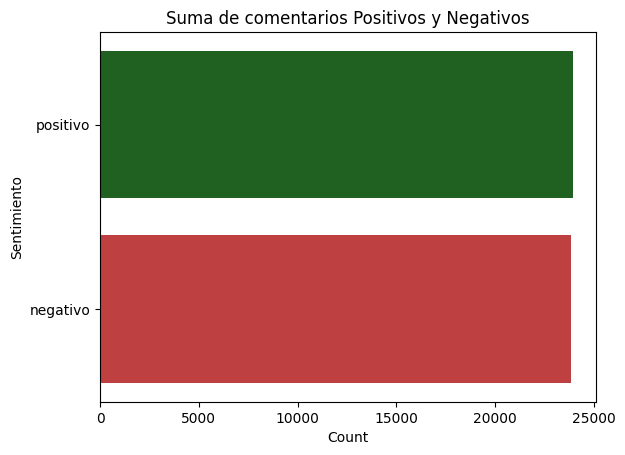

In [11]:
#Ahora vamos a extraer la información relevante a cerca de los sentimientos etiquetados para cada reseña:
negative = len(df[df['Sentimiento']=='negativo'])
positive = len(df) - negative
sns.countplot(data = df["Sentimiento"], palette = ["green","red"], saturation = 0.5)
plt.title("Suma de comentarios Positivos y Negativos")
plt.xlabel("Count")
plt.ylabel("Sentimiento")
print('{} reseñas son positivas y {} negativas respecto al total de {} reseñas.'.format(positive,negative,len(df)))

Como podemos observar, los sentimientos están dsitribuidos en 50.2% reseñas positivas y 49.8% reseñas negativas. 

Previamente hemos consultado los nulos tanto en la parte numérica como en la parte de texto, por lo tanto, podemos confirmar que estos datos son correctos.

**Longitud de Comentarios**

count    47783.000000
mean      1354.437227
std        940.317019
min         39.000000
25%        747.000000
50%       1031.000000
75%       1678.000000
max       5675.000000
Name: Longitud_Reseña, dtype: float64


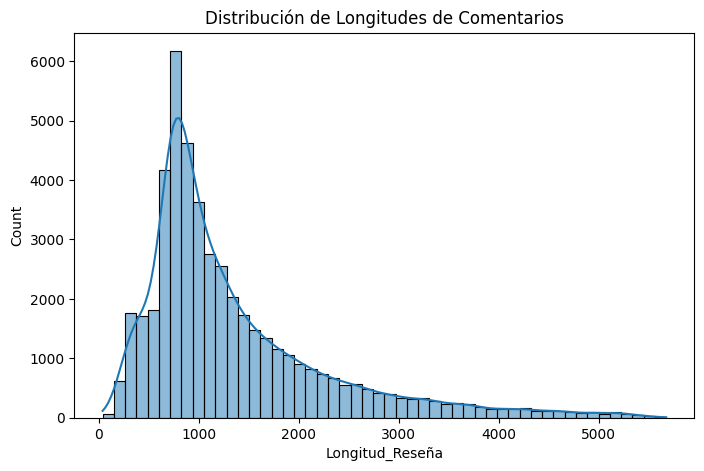

In [12]:
#Creamos una columna que recoja la longitud de las reseñas, es decir, la cantidad de caracteres que tienen.
df["Longitud_Reseña"] = df["Reseñas"].apply(len)

#Obseramos las estadisticas generales de las reseñas
print(df["Longitud_Reseña"].describe())

#Generamos un histograma para visualizar mejor los datos.
plt.figure(figsize=(8,5))
sns.histplot(df["Longitud_Reseña"], bins=50, kde=True)
plt.title("Distribución de Longitudes de Comentarios")
plt.show()

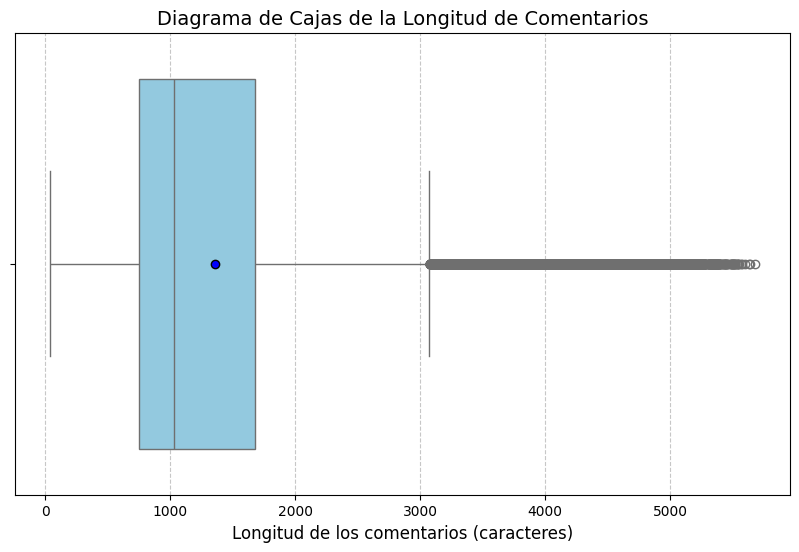

In [13]:
#Ahora realizamos un boxpalot para visualizar los mismos datos en un diagrama de cajas, simplemente para observarlo de otra forma.
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Longitud_Reseña"], color="skyblue", showmeans=True, meanprops={"marker":"o", "markerfacecolor":"blue", "markeredgecolor":"black"})

#Configuramos y mostramos el gráfico
plt.title("Diagrama de Cajas de la Longitud de Comentarios", fontsize=14)
plt.xlabel("Longitud de los comentarios (caracteres)", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()



Después de crear dos graficos, podemos visualizar de distintas formas como tenemos un sesgo positivo en los datos. 

También podemos considerar los datos sin outilers ya que al tener tantas reseñas, vemos que hay muchas que tienden a ser breves y unas pocas que son largas, lo cual no es extraño. 

In [14]:
#Obtenemos las 5 reseñas más largas del dataset.
reseñas_mas_largas = df.nlargest(5, "Longitud_Reseña")[["Reseñas", "Longitud_Reseña"]]

#Mostramos las reseñas de la lista creada anteriormente una por una.
for i, row in reseñas_mas_largas.iterrows():
    print(f"Reseña {i+1} (Longitud: {row['Longitud_Reseña']} caracteres):\n")
    print(row["Reseñas"][:100] + "...")  #Mostramos solo los primeros 100 caracteres
    print("-" * 100)  #Separador entre reseñas



Reseña 13369 (Longitud: 5675 caracteres):

El consumidor de huesos se encuentra en una pequeña ciudad desértica en Alabama, donde el desarrolla...
----------------------------------------------------------------------------------------------------
Reseña 9972 (Longitud: 5634 caracteres):

Título: Zombie 3 (1988) Directores: Mayormente Lucio Fulci, pero también Claudio Fragasso y Bruno Ma...
----------------------------------------------------------------------------------------------------
Reseña 23838 (Longitud: 5633 caracteres):

Esta película es tan mala que vale la pena ver. Esta película tendrá a los espectadores que retroced...
----------------------------------------------------------------------------------------------------
Reseña 19495 (Longitud: 5596 caracteres):

Revisión de la película de Daisy por James Mudge desde BeyondHolywood.comEn Papel, "Daisy" suena com...
----------------------------------------------------------------------------------------------------
Reseña 40

Observamos brevemente las 5 reseñas más largas y aparententemente son reseñas normales elaboradas, por lo tanto, las dejamos en el set de datos.

**Análisis de Palabras Frecuentes**

Ahora vamos a analizar las palabras más frecuentes en todas las reseñas que tenemos. \
Para ello utilizaremos CountVectorizer para que nos haga el sumatório de las palabras más usadas.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


película     150727
si            34898
solo          28554
películas     28532
historia      25951
ser           25908
tan           24709
ver           23995
realmente     23024
vez           19641
bien          17755
mejor         17445
gran          16825
puede         15930
hace          15542
tiempo        15253
después       14474
años          14399
hecho         14018
vida          13797
dtype: int64


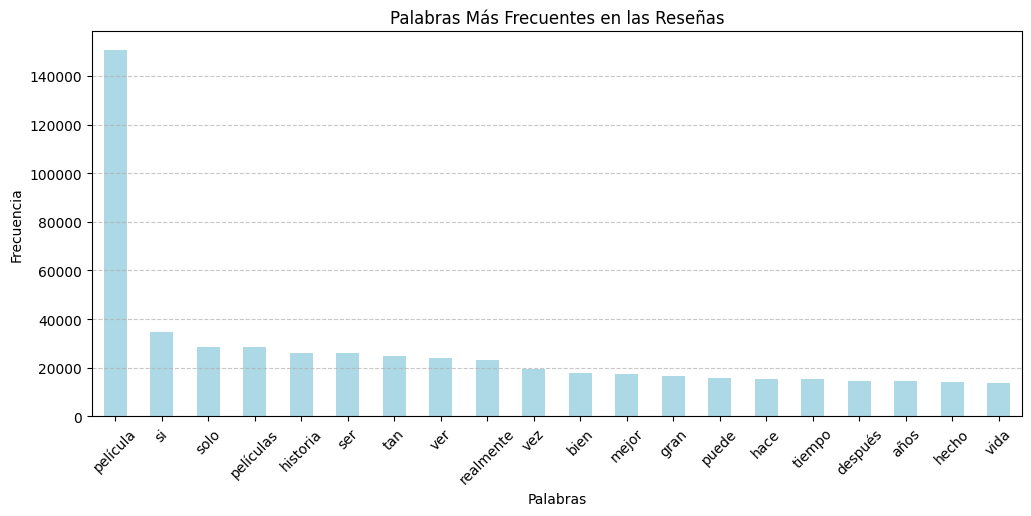

In [15]:
#Ahora vamos a analizar las palabras más frecuentes en todas las reseñas que tenemos. 
#Para ello utilizaremos CountVectorizer para que nos haga el sumatório de las palabras más usadas.

#Descargamos el StpoWords de NLTK
nltk.download('stopwords')

#Sacamos una lista de StopWords en Español
spanish_stopwords = stopwords.words('spanish')

#Definimos el vectorizador (CountVectorizer) con las StopWords definidas
vectorizer = CountVectorizer(stop_words=spanish_stopwords, max_features=20)  #Añadimos un máximo de 20 palabras a mostrar

#Aplicamos el vectorizador a todas nuestras reseñas
X = vectorizer.fit_transform(df['Reseñas'])

#Convertimos el resutlado en un DataFrame para mostrar los datos
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#Sumamos y mostramos el conteo de las palabras más frecuentes
top_words = word_counts.sum().sort_values(ascending=False)
print(top_words)

#Graficamos los resultados para poder verlos y asimilarlos mejor
plt.figure(figsize=(12, 5)) #Añadimos medidas para que las letras no se pisen entre sí en el gráfico
top_words.plot(kind='bar', color='lightblue')
plt.title("Palabras Más Frecuentes en las Reseñas")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45) #Rotamos un poco las palabras para que queden más legibles
plt.grid(axis='y', linestyle='--', alpha=0.7) #Añadimos líneas intermitentes al gráfico
plt.show()



Aquí podemos observar un gráfico que nos da las 20 palabras más frecuentes en nuestras reseñas. Como podemos observar, la palabra ganadora con mucha diferencia es 'película', con 150.727 repeticiones.

**Análisis de Emojis y Signos de Puntuación**

Ahora procedemos a analizar la presencia de emoticonos o signos de puntuación dentro de nuestras reseñas. \
Todos estos serán eliminados posteriormente, en el preprocesamiento de los datos, pero por ahora, podemos analizarlos.

In [16]:
#Realizamos el conteo de signos de exclamación e interrogación
df["exclamaciones"] = df["Reseñas"].apply(lambda x: len(re.findall(r"!+", x)))
df["interrogaciones"] = df["Reseñas"].apply(lambda x: len(re.findall(r"\?+", x)))

#Comparamos el promedio de las exclamaciones/interrogaciones según el sentimiento
df.groupby("Sentimiento")[["exclamaciones", "interrogaciones"]].mean()


,exclamaciones,interrogaciones
Sentimiento,,
negativo,0.707439,0.830342
positivo,0.662837,0.378107


Según esta pequeña tabla, podemos observar que en las reseñas de carácter negativo tenemos exclamaciones e interrocaciones casi por igual, aunque más interrogaciones que exclamaciones. \
Por otro lado, vemos una gran diferencia en las reseñas positivas, ya que podemos observar muchas más exclamaciones que interrogaciones.

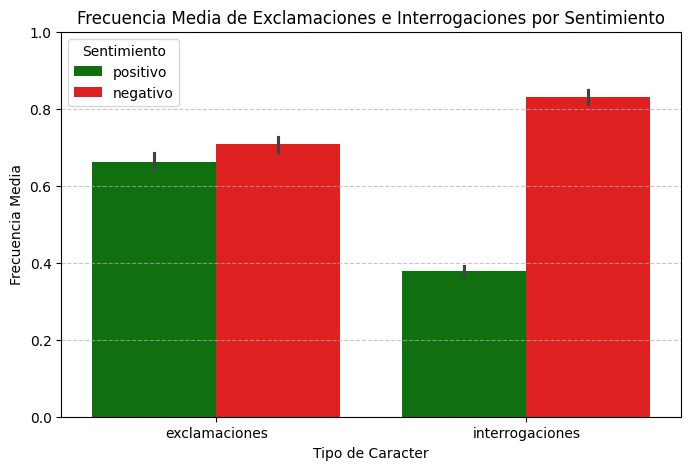

In [17]:
#Ahora vamos a extraer los mismos datos pero en un gráfico para que se visualizen mejor.
exclam_interrog_df = df[["Sentimiento", "exclamaciones", "interrogaciones"]].melt(id_vars="Sentimiento", 
                                                                              var_name="Caracter", 
                                                                              value_name="Frecuencia")

#Creamos, configuramos y mostramos el gráfico:
plt.figure(figsize=(8, 5))
sns.barplot(data=exclam_interrog_df, x="Caracter", y="Frecuencia", hue="Sentimiento", palette=["green", "red"])
plt.title("Frecuencia Media de Exclamaciones e Interrogaciones por Sentimiento")
plt.xlabel("Tipo de Caracter")
plt.ylabel("Frecuencia Media")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Por último, vamos a pasar la columna Sentimiento a binario, ya que solo existen 2 valores, les pondremos 0 y 1 siendo 0 negativas y 1 positivas.

In [18]:
#Aplicamos LabelEncoder a la columna 'Sentimiento' para pasarla a binario.
le = LabelEncoder()
df["Sentimiento"] = le.fit_transform(df["Sentimiento"])

dict(zip(le.classes_, le.transform(le.classes_)))
df.head()

,Reseñas,Sentimiento,Idioma,Longitud_Reseña,exclamaciones,interrogaciones
0,Uno de los otros críticos ha mencionado que de...,1,es,2004,0,0
1,Una pequeña pequeña producción.La técnica de f...,1,es,1061,1,0
2,Pensé que esta era una manera maravillosa de p...,1,es,989,0,1
3,"Básicamente, hay una familia donde un niño peq...",0,es,790,2,0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,es,1406,0,0


Por último, eliminamos las columnas que no nos interesan para el preprocesamiento de los datos y dejamos el dataset listo.

In [19]:
#Eliminamos las 4 columnas que hemos utilizado para el análisis y nos quedamos con las 2 columnas esenciales.
df = df.drop(["Idioma","Longitud_Reseña","exclamaciones","interrogaciones"], axis=1)
df.head()

,Reseñas,Sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


Con esto terminamos nuestro análisis exploratório del Dataset. Ahora pasaremos a la parte del preprocesamiento de los datos, pero antes, eliminamos las columnas innecesarias para el procesamiento del lenguaje natural y nos guardamos el dataset.

## NLP - Procesamiento del Lenguaje Natural

**Pasos a seguir en el preprocesamiento de los datos**
+ Limpieza del Texto
+ Lematización
+ Tokenización
+ Representación Numérica del Texto
+ Creación del Set de Datos de Entrenamiento y Prueba

**Limpieza del Texto**

En este paso lo que haremos será limpiar el texto de las reseñas de todo tipo de signos o frases que no necesitemos. \
También eliminaremos todas las StopWords en español, que son todas las palabras que no tienen un significado fuerte o esencial para el análisis de las reseñas.

In [20]:
#Descargamos recursos de NLTK, librería que nos ayudará a quitar StopWords
nltk.download("stopwords")
stop = list(stopwords.words("spanish"))

# --- Limpieza de Texto ---
def limpiar_texto(texto):
    texto = texto.lower()  #Convertir el texto a minúsculas
    texto = re.sub(r"http\S+", "", texto)  #Eliminamos URLs
    texto = re.sub(r"[^\w\s]", "", texto)  # Eliminamos signos de puntuación
    texto = re.sub("([^\x00-\x7F\u00C0-\u017F])+", " ", texto) #Eliminamos todos los carácteres no ASCII
    texto = demojize(texto)  #Aplicamos un conversor de emoticonos a texto

    #Creamos iteración para todas las reseñas del dataset
    filtro = [palabra for palabra in texto.split() if (len(palabra) > 2 or palabra == "no") and palabra.isalpha()]
    texto = " ".join(filtro)
    return texto

# --- Eliminación de StopWords ---
def eliminar_stopwords(texto):
    stopwords_esp = stopwords.words("spanish") #Esta variable guarda las StopWords en español
    palabras = texto.split() 
    #Iteramos sobre todas las reseñas de nuevo
    texto = [palabra for palabra in palabras if palabra not in stopwords_esp]
    return ' '.join(texto)

#Aplicamos las funciones de limpieza de texto definidas previamente para todas las filas del dataset y las guardamos como nueva columna
df["Reseñas_Limpias"] = df["Reseñas"].apply(lambda x: limpiar_texto(x))
df["Reseñas_Limpias"] = df["Reseñas_Limpias"].apply(lambda x: eliminar_stopwords(x))

#Mostramos un resumen de la cantidad de caracteres que hemos eliminado del dataset realizando la limpieza
SinStopWords= df["Reseñas"].str.len().sum()
ConStopWords= df["Reseñas_Limpias"].str.len().sum()
print("Total de carácteres en el dataset sin limpiar y con StopWords: %s y con limpieza y sin StopWords %s" %(SinStopWords,ConStopWords))
print("Se ha eliminado el", (1-(ConStopWords/SinStopWords))*100,"% de todos los caracteres del dataset")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de carácteres en el dataset sin limpiar y con StopWords: 64719074 y con limpieza y sin StopWords 43008897
Se ha eliminado el 33.54525282608339 % de todos los caracteres del dataset


In [21]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


You should consider upgrading via the 'c:\Users\Felix\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [22]:
#Cargamos el modelo en español (si no lo tienes instalado, ejecuta `!python -m spacy download es_core_news_sm`)
nlp = spacy.load("es_core_news_sm")

#Función para lematizar cada reseña
def lemmatizar(texto):
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc])

#Aplicamos la lematización a todas las reseñas
df["Reseñas_Lematizadas"] = df["Reseñas_Limpias"].apply(lemmatizar)

In [23]:
#Cramos el tokenizador con un vocabulario máximo de 30,000 palabras
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Reseñas_Lematizadas"])  #Ajustamos el tokenizador a las reseñas ya limpias y lematizadas

#Convertimos las reseñas en secuancias numéricas
secuencias = tokenizer.texts_to_sequences(df["Reseñas_Lematizadas"])

#Guardamos el índice de palabras (por si se necesita más tarde)
indice_de_palabras = tokenizer.word_index

#Mostramos un ejemplo de las primeras 5 reseñas
print(secuencias[:5])


[[481, 1304, 31, 6, 8, 184, 4187, 130, 473, 175, 1909, 23, 30, 395, 4415, 17, 470, 1, 40, 627, 230, 1250, 129, 517, 327, 2999, 129, 5052, 8475, 581, 683, 373, 470, 6349, 505, 233, 230, 284, 8369, 474, 25536, 1096, 1413, 11640, 1059, 590, 188, 29761, 1762, 3835, 1166, 33, 4251, 25537, 3818, 640, 246, 6602, 14329, 194, 4212, 3173, 803, 1, 3140, 10586, 4063, 1554, 800, 2065, 45, 351, 921, 2891, 255, 1348, 421, 8476, 48, 450, 12, 110, 495, 129, 21, 4, 129, 29762, 4851, 131, 606, 12691, 173, 1956, 647, 917, 13591, 708, 22499, 23, 184, 47, 375, 10, 650, 1661, 3, 12, 728, 5, 1563, 23919, 525, 1, 194, 396, 470, 989, 8, 470, 191, 6743, 2264, 15656, 195, 27422, 5885, 242, 1737, 1054, 1360, 3225, 5885, 387, 157, 113, 4328, 1166, 234, 740, 918, 5410, 386, 1166, 6, 3, 121, 5, 2239, 1077, 1530, 3, 21371, 1820, 213, 350], [85, 85, 1, 979, 1556, 13592, 305, 1255, 1882, 493, 1586, 11425, 11, 1077, 11, 1, 41, 436, 20, 1803, 379, 29763, 8, 1, 33, 278, 1, 3, 6, 531, 323, 10215, 890, 1637, 1865, 1439, 8, 2

In [24]:
#Creamos la columna Reseñas Tokenizadas, pasando así de tener una variable con los datos a tenerlos almacenados en nuestro dataset
df["Reseñas_Tokenizadas"] = secuencias

In [25]:
#Visualizamos la pinta de nuestro dataset hasta el momento
df.head()

,Reseñas,Sentimiento,Reseñas_Limpias,Reseñas_Lematizadas,Reseñas_Tokenizadas
0,Uno de los otros críticos ha mencionado que de...,1,críticos mencionado después ver solo episodio ...,crítico mencionado después ver solo episodio e...,"[481, 1304, 31, 6, 8, 184, 4187, 130, 473, 175..."
1,Una pequeña pequeña producción.La técnica de f...,1,pequeña pequeña producciónla técnica filmación...,pequeño pequeño producciónla técnico filmación...,"[85, 85, 1, 979, 1556, 13592, 305, 1255, 1882,..."
2,Pensé que esta era una manera maravillosa de p...,1,pensé manera maravillosa pasar tiempo fin sema...,pensar manera maravilloso pasar tiempo fin sem...,"[52, 70, 276, 98, 26, 449, 560, 1222, 61, 835,..."
3,"Básicamente, hay una familia donde un niño peq...",0,básicamente familia niño pequeño jake piensa z...,básicamente familia niño pequeño jake pensar z...,"[570, 228, 50, 85, 5527, 52, 1868, 2872, 156, ..."
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,amor tiempo petter mattei película visualmente...,amor tiempo petter mattei películar visualment...,"[135, 26, 1, 8477, 82, 1876, 458, 6, 8477, 372..."


Llegados a este punto ya tenemos los datos de las reseñas casi listos para meterlos a nuestro modelo, ya han sido limpiados, lematizados y tokenizados exitosamente. \
Ahora vamos a proceder a darle una longitud estipulada a todas las reseñas para poder ingestarlos correctamente en el modelo. 

Para ello tenemos que escoger que tamaño le damos a nuestras reseñas tokenizadas.

Para determinar que tamañan debemos asignarle a nuestras reseñas tokenizadas realizaremos un grafico para ver al distribución de la longitud de las reseñas tokenizadas

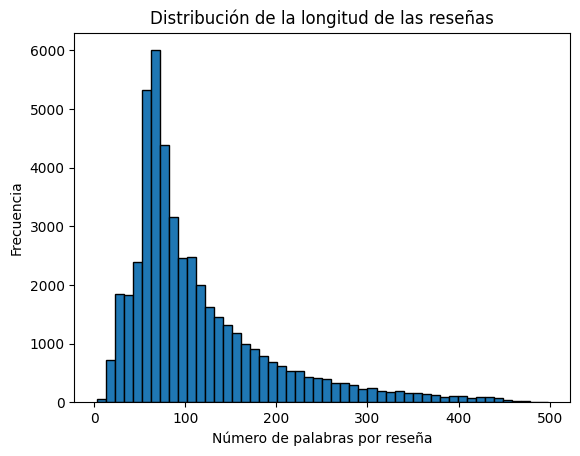

In [26]:
#Creamos una variable que almacene las longitudes de las reseñas
longitudes = [len(resena.split()) for resena in df["Reseñas_Lematizadas"]]

#Generamos el histograma
plt.hist(longitudes, bins=50, edgecolor="black")
plt.xlabel("Número de palabras por reseña")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de las reseñas")
plt.show()


Observamos en el grafico que la gran mayoria de als reseñas tienen entre 75 y 200 palabras por reseña, por lo tanto, para estar seguros de coger la máxima cantidad de palabras diferentes posibles y así tener un mejor bocabulario seleccionamos 250 palabras por reseña.

Las palabras que sobren en las reseñas más largas se cortarán y las palabras que falten en las reseñas más cortas serán substituidas por 0.

In [27]:
#Definimos la longitud máxima 
MAX_LEN = 250  

#Aplicamos padding para que todas las secuencias tengan la misma longitud
secuencias_padded = pad_sequences(secuencias, maxlen=MAX_LEN, padding="post", truncating="post")

print(secuencias_padded.shape)  #Observamos el tamaño del dataset vectorizado

#Convertimos la secuencia a una lista de listas
secuencias_list = secuencias_padded.tolist()

#Agragamos la lista como una nueva columna al DataFrame
df["Reseña_Tokenizada_Recortada"] = secuencias_list
df.head()


(47783, 250)


,Reseñas,Sentimiento,Reseñas_Limpias,Reseñas_Lematizadas,Reseñas_Tokenizadas,Reseña_Tokenizada_Recortada
0,Uno de los otros críticos ha mencionado que de...,1,críticos mencionado después ver solo episodio ...,crítico mencionado después ver solo episodio e...,"[481, 1304, 31, 6, 8, 184, 4187, 130, 473, 175...","[481, 1304, 31, 6, 8, 184, 4187, 130, 473, 175..."
1,Una pequeña pequeña producción.La técnica de f...,1,pequeña pequeña producciónla técnica filmación...,pequeño pequeño producciónla técnico filmación...,"[85, 85, 1, 979, 1556, 13592, 305, 1255, 1882,...","[85, 85, 1, 979, 1556, 13592, 305, 1255, 1882,..."
2,Pensé que esta era una manera maravillosa de p...,1,pensé manera maravillosa pasar tiempo fin sema...,pensar manera maravilloso pasar tiempo fin sem...,"[52, 70, 276, 98, 26, 449, 560, 1222, 61, 835,...","[52, 70, 276, 98, 26, 449, 560, 1222, 61, 835,..."
3,"Básicamente, hay una familia donde un niño peq...",0,básicamente familia niño pequeño jake piensa z...,básicamente familia niño pequeño jake pensar z...,"[570, 228, 50, 85, 5527, 52, 1868, 2872, 156, ...","[570, 228, 50, 85, 5527, 52, 1868, 2872, 156, ..."
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,amor tiempo petter mattei película visualmente...,amor tiempo petter mattei películar visualment...,"[135, 26, 1, 8477, 82, 1876, 458, 6, 8477, 372...","[135, 26, 1, 8477, 82, 1876, 458, 6, 8477, 372..."


Una vez ya hemos hecho esto, podemos pasar al último paso del preprocesamiento de los datos, que es dividir los datos en los conjuntos de entrenamiento y prueba.

In [28]:
#Convertimos a arrays las columnas necesarias usando NumPy
x = np.array(df["Reseña_Tokenizada_Recortada"].tolist())  #Reseñas tokenizadas recortadas
y = np.array(df["Sentimiento"].tolist())  #Etiquetas de sentimiento de las reseñas

#Dividimos en datos de entrenamiento (80%) y validación (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [29]:
#Observamos brevemente el tamaño de los conjuntos
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38226, 250), (9557, 250), (38226,), (9557,))

Ahora ya damos por finalizado el preprocesamiento de los datos y podemos pasar a la creación y ejecución de la Red Neuronal.

## Construcción de la Red Neuronal (DNN)

**Pasos a seguir en la construcción de la Red Neuronal**
+ Creamos el modelo
+ Compilamos y entrenamos el modelo
+ Evaluamos el modelo en los datos de prueba
+ Sacamos nuestras conclusiones
+ Hacemos pruebas del modelo sobre el conjunto de prueba 

Construimos y entrenamos un LSTM, un modelo memoria a corto-largo plazo, la cual es una red neuronal recurrente RNN. \
Esta será utilizada para aprender, procesar y clasificar datos secuenciales que serán las reseñas ya trabajadas previamente.

In [30]:
#Creamos el modelo secuencial
model = Sequential()
model.add(Embedding(input_dim=30000, output_dim=128)) #Añadimos una capa de embedding para representar las palabras en vectores de tamaño 128
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) #Agregamos una capa LSTM con 128 unidades y dropout para evitar sobreajuste
model.add(Dense(1, activation="sigmoid")) #Añadimos una última capa densa con activación sigmoide para clasificar entre 0 y 1

In [31]:
#Compilamos utilizando el modelo de optimización Adam, la función de pérdida binaria (ya que tenemos un problema de clasificación bianria) y como metrica usamos la precisión (accuracy)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
#Entrenamos el modelo con los datos de entrenamiento, utilizando un tamaño de lote de 64 y entrenamos durante 5 épocas. Por último, reservamos el 20% de los datos para la validación
historial = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 117s 245ms/step - accuracy: 0.8053 - loss: 0.4528 - val_accuracy: 0.8220 - val_loss: 0.4204
Epoch 2/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 111s 232ms/step - accuracy: 0.9077 - loss: 0.2581 - val_accuracy: 0.8527 - val_loss: 0.3955
Epoch 3/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 103s 216ms/step - accuracy: 0.9462 - loss: 0.1721 - val_accuracy: 0.8485 - val_loss: 0.4298
Epoch 4/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - accuracy: 0.9665 - loss: 0.1175 - val_accuracy: 0.8471 - val_loss: 0.4724
Epoch 5/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9768 - loss: 0.0857 - val_accuracy: 0.8408 - val_loss: 0.5526


In [37]:
#Convertimos las secuencias y las etiquetas en listas por si están en formato string para evitar errores
x_test = np.array([ast.literal_eval(x) if isinstance(x, str) else x for x in x_test])
y_test = np.array([int(y) if isinstance(y, str) else y for y in y_test])


In [38]:
#Evaluamos la pérdida y la precisión en los datos de prueba
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8365 - loss: 0.5644
Test Loss: 0.5638294816017151
Test Accuracy: 0.8376059532165527


**Una vez llegamos aquí, podemos dar por concluido el trabajo, pero antes comentaremos un poco los datos obtenidos:**
+ Entrenamiento del modelo:
    La precisión del modelo alcanza el 97,68% en la última época, lo que indica que ha aprendido muy bien los datos de entrenamiento.
    La pérdida en el entrenamiento disminuye progresivamente desde 0.452 hasta 0.0857, lo que indica que el modelo está optimizado correctamente.
    La precisión de la validación se mantiene estable en torno al 84%, lo cual es un resultado moderadamente bueno, pero no el mejor.
    Por último, la pérdida en la validación aumenta de 0.42 a 0.55, lo que sugiere un sobreajuste en los datos. Esto nos indica que el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza tan bien en datos nuevos.

+ Evaluación en los datos de prueba:
    Precisión en prueba del 83.7%, lo que se mantiene en la línea con la precisión de validación (aproximadamente 84%), indicando un modelo estable.
    Perdida en prueba de 0.56, lo que nos confirma el sobreajuste detectado en validación.

**Conclusiones**
- Alto rendimiento en entrenamiento pero tiene sobreajuste.
- Posible mejora para reducir el sobreajuste aplicando más dropout o, aumentando los datos de entrenamiento. La segunda opción es la relevante en este caso ya que con datos de entrenamiento tenemos 38,000, los cuales son suficientes.
- Buen desempeño general, a pesar de su sobreajuste es capaz de obetener buena precisión en datos nuevos.

Por último, antes de concluir, mostramos un breve código en el que se muestran pruebas aleatórias del conjunto de datos de prueba, para que el modelo realize una predicción y poder comprobar su funcionamiento y eficiencia.

In [42]:
#Seleccionamos 5 reseñas aleatorias del set de prueba
indices_aleatorios = random.sample(range(len(x_test)), 5)
muestras = x_test[indices_aleatorios]
etiquetas_reales = y_test[indices_aleatorios]
reseñas_seleccionadas = df.iloc[indices_aleatorios]["Reseñas"] 

#Hacemos las predicciones con nuestro modelo
predicciones = model.predict(muestras)

#Mostramos los resultados
for i in range(len(muestras)):
    print(f"Reseña {i+1}: {reseñas_seleccionadas.iloc[i][:300]}...")  #Mostramos solo los primeros 300 caracteres
    print(f"Etiqueta real: {'Positiva' if etiquetas_reales[i] == 1 else 'Negativa'}")
    print(f"Predicción cruda: {predicciones[i][0]:.4f}")
    print(f"Clasificación final: {'Positiva' if predicciones[i][0] > 0.5 else 'Negativa'}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Reseña 1: Algún humor divertido, algunos que caen planos, algunas actuaciones decentes, algunas que son bastante atroz.Esta película es simplemente impétida y se pierde, garantizada para divertir a los niños de 12 años más que cualquier otro nicho. Los actores infantiles en la película son simplemente UNFUNNY...
Etiqueta real: Negativa
Predicción cruda: 0.0057
Clasificación final: Negativa
--------------------------------------------------
Reseña 2: Película rompiendo sobre la fabricación de cine.Muestra las relaciones intensas y extrañas que pueden desarrollarse entre los directores y sus actores;la manipulación y los juegos de la mente;El egotismo de preparación de los artistas.Al igual que en cualquier lugar de trabajo, la sexualidad complic...
Etiqueta real: Positiva
Predicción cruda: 0.9929
Clasificación final: Positiva
--------------------------------------------------
Reseña 3: El cine de los años 60 fue tanto como el tiempo de revolución co